In [16]:

%matplotlib inline

import os
import torch
import trimesh
import numpy as np
import torch.nn as nn

if os.getcwd().split("\\")[-1] != "toytorch":
    os.chdir(os.path.join(os.getcwd(), "../"))

from deepSDF.config import Configuration
from deepSDF.synthesize import Synthesizer
from deepSDF.model import SDFdataset, SDFdecoder, SDFdecoderTrainer
from deepSDF.data.data_creator import DataCreator, DataCreatorHelper

In [ ]:
# Visualizing raw skyscrapers

path = Configuration.RAW_DATA_PATH
meshes = trimesh.Trimesh(vertices=[], faces=[])

for i, file in enumerate(os.listdir(path)):
    if file.endswith(".obj"):
        mesh = trimesh.load(os.path.join(path, file))

        if isinstance(mesh, trimesh.Scene):
            geo_list = []
            for g in mesh.geometry.values():
                geo_list.append(g)
            mesh = trimesh.util.concatenate(geo_list)

        mesh.fix_normals(multibody=True)
        
        meshes += mesh
        
# If you want to see the raw data, uncomment the following lines.

# scene = trimesh.Scene(meshes)
# scene.set_camera(angles=[90, 90, 90])
# scene.show()


In [ ]:
# Preprocessing data

data_creator = DataCreator(
    n_surface_sampling=Configuration.N_SURFACE_SAMPLING,
    n_bbox_sampling=Configuration.N_BBOX_SAMPLING,
    n_volume_sampling=Configuration.N_VOLUME_SAMPLING,
    raw_data_path=Configuration.RAW_DATA_PATH,
    save_path=Configuration.SAVE_DATA_PATH,
    translate_mode=DataCreatorHelper.CENTER_WITHOUT_Z,
    dynamic_sampling=False,
    is_debug_mode=False,
)

data_creator.create()

In [ ]:
# Training model

sdf_dataset = SDFdataset()
sdf_decoder = SDFdecoder(cls_nums=sdf_dataset.cls_nums)
sdf_trainer = SDFdecoderTrainer(
    sdf_dataset=sdf_dataset,
    sdf_decoder=sdf_decoder,
    is_debug_mode=False,
    seed=77777,
    pre_trained_path=r"deepSDF\runs\2024-03-24_12-40-26",
)

sdf_trainer.train()

In [ ]:
# Visualizing reconstructed skyscrapers from the trained latent codes

"""
    cls_dict = {
        0: 'bank_of_china',
        1: 'burj_al_arab',
        2: 'cctv_headquarter',
        3: 'china_zun',
        4: 'empire_state_building',
        5: 'hearst_tower',
        6: 'kingdom_centre',
        7: 'lotte_tower',
        8: 'mahanakhon',
        9: 'one_world_trade_center',
        10: 'shanghai_world_financial_center',
        11: 'taipei_101',
        12: 'the_gherkin',
        13: 'the_shard',
        14: 'transamerica_pyramid'
    }
"""

all_states = torch.load(r"deepSDF\runs\2024-03-24_12-40-26\states\all_states.pth")
cls_dict = all_states["cls_dict"]

sdf_decoder = SDFdecoder(cls_nums=max(cls_dict.keys()) + 1)
sdf_decoder.load_state_dict(all_states["model_d"])
sdf_decoder.latent_codes = nn.Parameter(all_states["latent_codes"])

sdf_trainer = SDFdecoderTrainer(
    sdf_dataset=None,
    sdf_decoder=sdf_decoder,
    seed=77777,
    is_reconstruct_mode=True,
)

os.makedirs(r"deepSDF\runs\2024-03-24_12-40-26\reconstructed_after_training", exist_ok=True)

mesh_interval = 1
meshes = trimesh.Trimesh(vertices=[], faces=[])
for cls_num in cls_dict.keys():
    
    obj_path = f"deepSDF\\runs\\2024-03-24_12-40-26\\reconstructed_after_training\\{cls_num}.obj"
    
    if os.path.exists(obj_path.replace(".obj", f"_{None}_{cls_dict[cls_num]}.obj")):
        continue

    sdf_trainer.reconstruct(
        sdf_decoder=sdf_decoder,
        cls_dict=cls_dict,
        obj_path=obj_path,
        epoch=None,
        cls_num=cls_num,
        map_z_to_y=True,
    )
    
    mesh = trimesh.load(obj_path.replace(".obj", f"_{None}_{cls_dict[cls_num]}.obj"))

    if isinstance(mesh, trimesh.Scene):
        geo_list = []
        for g in mesh.geometry.values():
            geo_list.append(g)
        mesh = trimesh.util.concatenate(geo_list)

    mesh.fix_normals(multibody=True)
    
    mesh.vertices += np.array([mesh_interval * cls_num, 0, 0])
    
    meshes += mesh
    
# If you want to see the skyscrapers generated by model, uncomment the following lines.

# scene = trimesh.Scene(meshes)
# scene.set_camera(angles=[90, 90, 90])
# scene.show()    

In [1]:
# Synthesizing trained data

import os

if os.getcwd().split("\\")[-1] != "toytorch":
    os.chdir(os.path.join(os.getcwd(), "../"))

import torch
import torch.nn as nn
import gc

torch.cuda.empty_cache()
gc.collect()

from deepSDF.model import SDFdecoder
from deepSDF.synthesize import infinite_synthesis


"""
    cls_dict = {
        0: 'bank_of_china',
        1: 'burj_al_arab',
        2: 'cctv_headquarter',
        3: 'china_zun',
        4: 'empire_state_building',
        5: 'hearst_tower',
        6: 'kingdom_centre',
        7: 'lotte_tower',
        8: 'mahanakhon',
        9: 'one_world_trade_center',
        10: 'shanghai_world_financial_center',
        11: 'taipei_101',
        12: 'the_gherkin',
        13: 'the_shard',
        14: 'transamerica_pyramid'
    }
"""

all_states = torch.load(r"deepSDF\runs\2024-03-24_12-40-26\states\all_states.pth")
cls_dict = all_states["cls_dict"]
cls_nums = max(cls_dict.keys()) + 1

sdf_decoder = SDFdecoder(cls_nums=cls_nums)
sdf_decoder.load_state_dict(all_states["model_d"])
sdf_decoder.latent_codes = nn.Parameter(all_states["latent_codes"])

infinite_synthesis(
    sdf_decoder=sdf_decoder,
    save_dir=r"deepSDF\runs\2024-03-24_12-40-26\infinite_synthesis",
    resolution=256,
    map_z_to_y=True,
    check_watertight=True,
)

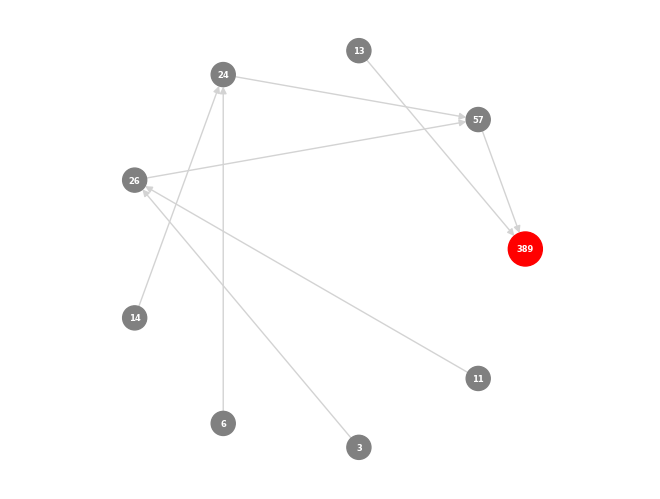

In [43]:
import numpy as np
import random
from deepSDF.synthesize import visualize_traced_data_as_graph, trace_back_to_origin

# random.seed(77777)

latent_codes_data = np.load(
    r"deepSDF\runs\2024-03-24_12-40-26\infinite_synthesis\infinite_synthesized_latent_codes.npz",
    allow_pickle=True
)["synthesized_data"]

index = random.randint(0, len(latent_codes_data))

visualize_traced_data_as_graph(
    latent_codes_data, 
    index=index
)